You are given an excerpt of the log data from the [Swisslos](https://www.swisslos.ch) Jass servers collected between October 2017 and April 2018. In the Swiss card game [Jass](https://en.wikipedia.org/wiki/Jass), at the beginning of each round just after the cards have been dealt, the current player announces her choice of the trump mode from the options: diamonds, hearts, spades, club, obe-abe, une-ufe and push (only available when forehand). Use this information from human players to train a machine learning classifier in trump mode prediction.

In [3]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import & Prepare Data

In [4]:
path_to_data = Path('../data')

In [5]:
# Import only a fraction of data for efficient development and testing
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None, nrows=1000)

# Import all data in the final run
# data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4


In [6]:
# Display number of rows and columns
data.shape

(1000, 39)

## Rename Columns for better Interpretability

In [7]:
cards = [
    # Diamonds
    'DA', 'DK', 'DQ', 'DJ', 'D10', 'D9', 'D8', 'D7', 'D6',
    # Hearts
    'HA', 'HK', 'HQ', 'HJ', 'H10', 'H9', 'H8', 'H7', 'H6',
    # Spades
    'SA', 'SK', 'SQ', 'SJ', 'S10', 'S9', 'S8', 'S7', 'S6',
    # Clubs
    'CA', 'CK', 'CQ', 'CJ', 'C10', 'C9', 'C8', 'C7', 'C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user = ['user']
trump = ['trump']

data.columns = cards + forehand + user + trump
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CQ,CJ,C10,C9,C8,C7,C6,FH,user,trump
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4


<Axes: >

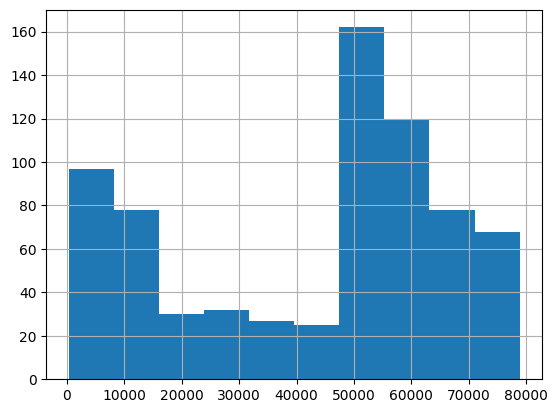

In [8]:
data[data['user'] > 0]['user'].hist()

## Remove User Information

Before removing the user column, we remove the combinations that were never played

In [9]:
data = data[data['user'] > 0]

Later on you may want to keep this information. For now, we remove it just to avoid mistakes.

In [10]:
data.drop('user', axis='columns', inplace=True)
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,6
1,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,5
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,5
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,4


## Adjust Datatypes

In [11]:
data.trump = data.trump.astype('category')
data[cards + forehand] = data[cards + forehand].astype(bool)
#data.dtypes

## Rename Target Category Values for better Interpretability

In [12]:
# Backward compatibility: Value 10 for PUSH was used in an older version by Swisslos

data.trump = data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3: 'CLUBS',
                                               4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'})
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,False,False,False,True,True,False,True,True,False,False,...,False,True,False,False,False,True,False,False,False,PUSH
1,False,False,False,False,False,False,False,False,True,True,...,False,False,True,False,False,False,True,False,False,UNE_UFE
2,True,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,True,True,False,PUSH
3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,True,False,False,False,False,UNE_UFE
4,False,True,False,False,False,False,False,False,True,True,...,False,False,True,False,False,False,False,False,True,OBE_ABE


# Data Quality Assessment

### Exercise: Sanity Check

Each row in the data now corresponds to one hand of a player plus her trump mode selection. Verify that each hand contains exactly 9 cards.

In [13]:
data[data.loc[:, cards].sum(axis=1) != 9].shape

(0, 38)

### Exercise: Statistical Fingerprint

Swisslos claims to distribute cards randomly.
* Verify that all card features roughly have the same mean and standard deviation.
* Over a **large number of rounds**, we would expect similar percentages for diamonds, hearts, spades and clubs as selected Trump. Verify this claim.

Hint: you may want to use [np.allclose(...)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html) in combination with an assert statement for automated checking.

#### A note on randomness - not part of exercises: 

The above test is obviously a very poor guarantee of randomness. However, we perform such tests from the viewpoint of data quality rather than fairness. If you want to challenge the random number generator of Swisslos, use the NIST or Diehard test suite for randomness. Read more about random number tests <a href='https://gerhardt.ch/random.php'>here</a>. We have not done this ourselves and keep believing that the provider of Swiss lottery use a reasonable source of randomness even for online games :-)

In [14]:
# Step 1: Calculate mean and standard deviation of each card feature
card_features = data.select_dtypes(include=[bool])
means = card_features.mean()
std_devs = card_features.std()

# Verify if all means and standard deviations are roughly the same
mean_close = np.allclose(means, means.mean(), rtol=0.05)
std_dev_close = np.allclose(std_devs, std_devs.mean(), rtol=0.05)

# Extract and normalize counts of trump categories
trump_counts = data['trump'].value_counts(normalize=True)

# Ensure only suits are compared (filter out invalid categories like 'PUSH', etc.)
suits = ['DIAMONDS', 'HEARTS', 'SPADES', 'CLUBS']  # Assuming these are the suits
actual_percentages = [trump_counts.get(suit, 0) for suit in suits]

# Expected percentages for equal distribution
expected_percentages = [1 / 4] * len(suits)  # 25% for each suit
trump_close = np.allclose(actual_percentages, expected_percentages, rtol=0.1)

mean_close, std_dev_close, trump_close

(False, False, False)

In [15]:
data.trump.value_counts()

trump
PUSH        282
UNE_UFE      85
CLUBS        80
OBE_ABE      74
SPADES       72
HEARTS       71
DIAMONDS     53
Name: count, dtype: int64

Can you explain ...
* the difference between Une-Ufe and Obe-Abe ?
* the difference between {spades, clubs} and {hearts, diamonds}

The fact that the values of the response are not distributed evenly has implications on the train-test split in the next section.

# Modelling and Prediction

### Train-Test Split

Split the available data into a training and a test set and put the test set aside for the final model evaluation. Use 20% of the data for testing, and set the random_state to 42 for reproducability. Since we found out that the classes are not distributed evenly, you need to stratify. Also, be aware that train_test_split() shuffles the data by default, which is what we want here (but not always, e.g. not in case of time series).

Your result should be the four variables *X_train, X_test, y_train, y_test*.

In [16]:
from sklearn.model_selection import train_test_split

feature_columns = cards + forehand
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data.trump, test_size=0.2,
                                                    stratify=data.trump, random_state=42)

## Baseline with a Logistic Regression Classifier

We create a (linear) logistic regression classifier and evaluate it with cross validation.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

classifier = LogisticRegression()

# Note that we do not use the test set here !
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

Mean accuracy over 5 folds is 0.5654


### Exercise: Stochastic Gradient Descent

Machine learning classifiers internally use an optimization algorithm. Stochastic gradient descent is a stochastic 
approximation that generally is more efficient but with a slightly lower convergence rate. Change the code in the previous cell to a logistic regression with stochastic gradient descent. Use [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) with parameters *loss='log'* and *penalty='None'*

In [18]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log_loss', penalty=None)

# Note that we do not use the test set here !
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

Mean accuracy over 5 folds is 0.5007


## Learning Curves

Learning curves are an important diagnostic instrument in machine learning. A cross-validation generator splits the whole dataset k times into training and test data. Subsets of the training set with increasing sizes will be used to train the estimator and a score for each training subset size on the validation set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

As a rule of thumb, a gap between the training and validation curves indicates that using more data would improve accuracy.

In [19]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(SGDClassifier(loss='log_loss', penalty=None),
                                                         X_train, y_train, n_jobs=-1,
                                                         train_sizes=np.linspace(0.1, 1.0, 50), cv=10,
                                                         exploit_incremental_learning=True, verbose=10)

[learning_curve] Training set sizes: [ 51  60  70  79  89  98 108 117 127 136 146 155 165 174 183 193 202 212
 221 231 240 250 259 269 278 287 297 306 316 325 335 344 354 363 373 382
 392 401 410 420 429 439 448 458 467 477 486 496 505 515]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:    1.8s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.8s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    1.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


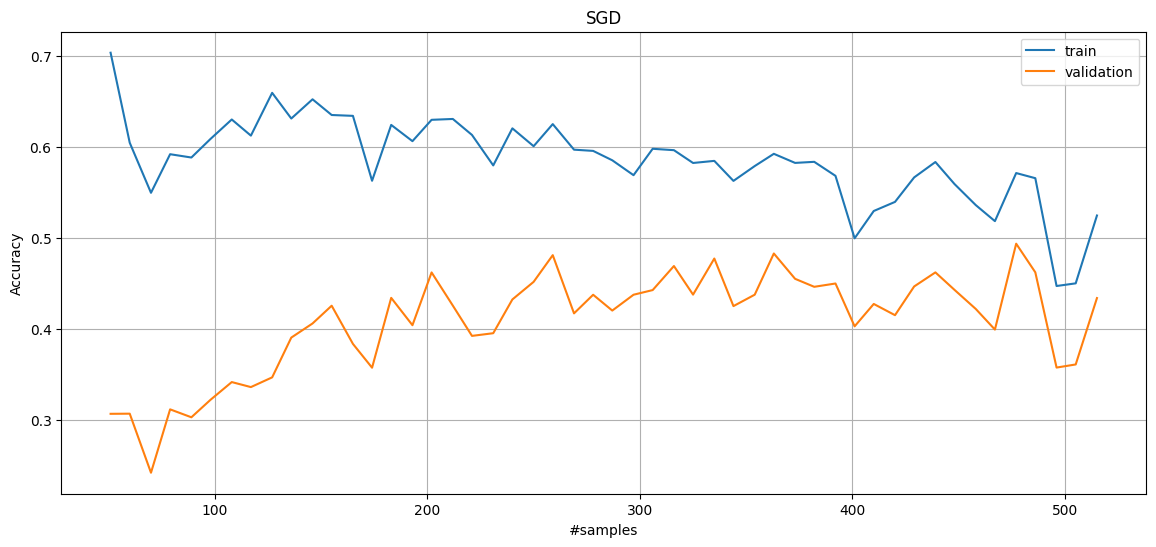

In [20]:
plot_data = pd.DataFrame({'train': train_scores.mean(axis=1), 'validation': valid_scores.mean(axis=1)},
                         index=train_sizes)
f, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel('#samples')
ax.set_ylabel('Accuracy')
ax.set_title('SGD')
plot_data.plot(ax=ax)
plt.grid()

### Exercise: Create a Random Forest Classifier

Now create a random forest classifier and evaluate it with cross validation.

In [21]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=0)

# Cross-validation: evaluates the model but does NOT fit the original classifier
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

classifier.fit(X_train, y_train)

Mean accuracy over 5 folds is 0.5305


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Exercise: List and Plot Feature Importances

Tree classsifiers (such as decision trees and random forests) can conveniently list feature importances. They use feature values to split the training set, whereas more important features are used higher in the tree(s). Use the *feature_importances_* attribute of a trained RandomForestClassifier to obtain a sorted list of the most important features. Plot feature importances in a bar chart.

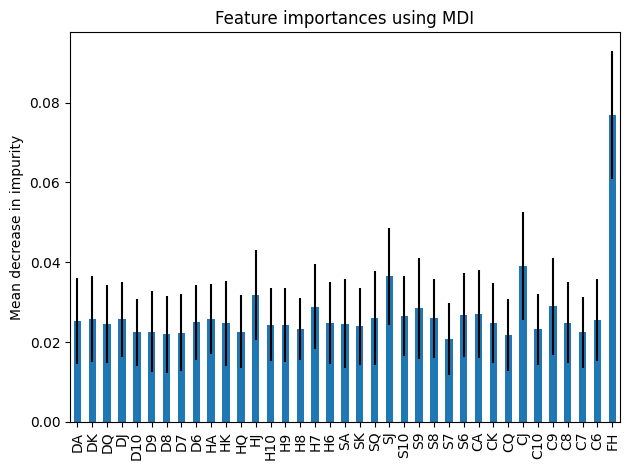

In [22]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Grid Search over multiple Classifiers and Hyperparameters

In [23]:


# Classifier names
names = [
    "Logistic Regression",
    "Random Forest"
]

# Classifiers
classifiers = [
    LogisticRegression(solver='lbfgs'),
    RandomForestClassifier(n_estimators=200)
]

# Hyperparameter grid to search per classifier
parameters = [
    {'C': [0.5, 1.0, 2.0]},
    {'max_depth': [5, 10]}
]

list(zip(names, parameters))

[('Logistic Regression', {'C': [0.5, 1.0, 2.0]}),
 ('Random Forest', {'max_depth': [5, 10]})]

In [24]:
from sklearn.model_selection import GridSearchCV

results = []

for name, classifier, params in zip(names, classifiers, parameters):
    print("Grid search for {}".format(name))
    gs = GridSearchCV(classifier, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train, y_train)
    print("Best accuracy score found: {:.3f}\n".format(gs.best_score_))
    results.append([name, gs.best_score_, gs.best_estimator_])

results

Grid search for Logistic Regression
Best accuracy score found: 0.578

Grid search for Random Forest
Best accuracy score found: 0.550



[['Logistic Regression',
  np.float64(0.5776201372997711),
  LogisticRegression(C=0.5)],
 ['Random Forest',
  np.float64(0.549672006102212),
  RandomForestClassifier(max_depth=5, n_estimators=200)]]

Comment: If *refit=True* (the default), the best estimator is made available at the *best_estimator_* attribute of gs and permits using *.predict()* directly on this GridSearchCV instance. Note, however, that the above code runs grid search separately for each classifier, and so gs now only contains the last estimator of the list, which may or may not be the best one. So don't use gs to predict blindly.

### Exercise: Extend Grid Search by adding other Classifiers and Hyperparameters

You may want to experiment with a [nearest neighbors classifier](http://scikit-learn.org/stable/modules/neighbors.html) or a [support vector machine](http://scikit-learn.org/stable/modules/svm.html) or a [neural network](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) or ...

### Exercise: Add interactions to Logistic Regression

A linear classifier such as logistic regression cannot model dependencies between features (things like "if your hand has both heart jack and heart nine, then choose heart as trump mode"). But features like these called *interactions* can be added manually.

In [25]:
# First, get the score without interactions
clf = LogisticRegression(C=0.8, solver='lbfgs')
result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

Mean accuracy over 5 folds is 0.5706


For each of the four colors, add one interaction term for the combination jack and nine.

In [26]:
for color in 'DHSC':
    # Jack and nine combination
    new_col_J9 = '{}_J9'.format(color)
    data[new_col_J9] = data['{}J'.format(color)] & data['{}9'.format(color)]
    feature_columns.append(new_col_J9)

    # Exercise: Add other features here such as the combination of Ace-King-Queen (Dreiblatt).
    # Ace-King-Queen (Dreiblatt) combination
    new_col_AKQ = '{}_AKQ'.format(color)
    data[new_col_AKQ] = data['{}A'.format(color)] & data['{}K'.format(color)] & data['{}Q'.format(color)]
    feature_columns.append(new_col_AKQ)

data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,FH,trump,D_J9,D_AKQ,H_J9,H_AKQ,S_J9,S_AKQ,C_J9,C_AKQ
0,False,False,False,True,True,False,True,True,False,False,...,False,PUSH,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,True,...,False,UNE_UFE,False,False,False,False,False,False,False,False
2,True,False,False,True,False,False,False,False,False,False,...,False,PUSH,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,...,False,UNE_UFE,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,True,True,...,True,OBE_ABE,False,False,False,True,False,False,False,False


We must recreate training and test sets with the new features

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data.trump, test_size=0.2,
                                                    stratify=data.trump, random_state=42)

X_train.columns

Index(['DA', 'DK', 'DQ', 'DJ', 'D10', 'D9', 'D8', 'D7', 'D6', 'HA', 'HK', 'HQ',
       'HJ', 'H10', 'H9', 'H8', 'H7', 'H6', 'SA', 'SK', 'SQ', 'SJ', 'S10',
       'S9', 'S8', 'S7', 'S6', 'CA', 'CK', 'CQ', 'CJ', 'C10', 'C9', 'C8', 'C7',
       'C6', 'FH', 'D_J9', 'D_AKQ', 'H_J9', 'H_AKQ', 'S_J9', 'S_AKQ', 'C_J9',
       'C_AKQ'],
      dtype='object')

And check  if the additional columns improve the score

In [28]:
clf = LogisticRegression(C=0.5, solver='lbfgs')
result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

clf.fit(X_train, y_train)

Mean accuracy over 5 folds is 0.5898


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.5
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


45


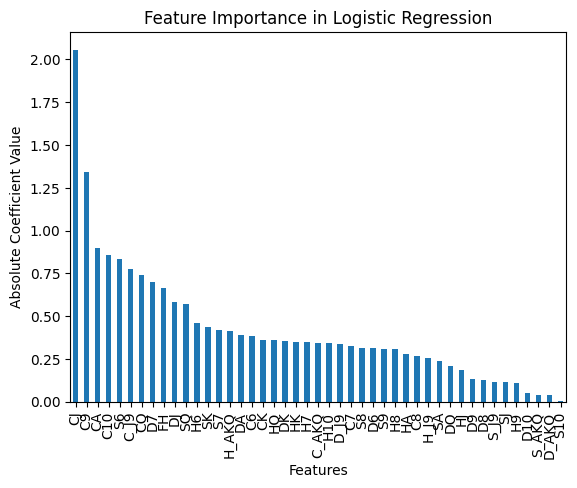

In [29]:
new_feature_columns = (
        cards
        + forehand
        + ["D_J9", "D_AKQ", "H_J9", "H_AKQ", "S_J9", "S_AKQ", "C_J9", "C_AKQ"]
)
print(len(new_feature_columns))

# Get feature importance (coefficients)
feature_importance = pd.Series(clf.coef_[0], index=new_feature_columns)

# Sort by absolute importance
feature_importance = feature_importance.abs().sort_values(ascending=False)

# Visualize feature importance
feature_importance.plot(kind='bar', title="Feature Importance in Logistic Regression")
plt.xlabel("Features")
plt.ylabel("Absolute Coefficient Value")
plt.show()

### Exercise: Better Accuracy with less Data ?

At the beginning we removed the user ID from our data set. Use this information to develop a heuristic that seggregates between *good* and *bad* players. Can you improve accuracy by using only the data from *good* players?

In [30]:
# solved in pre processing part at the beginning of the notebook

### Exercise: The final Score

Use the best setting you could find, train the classifier on all training data and evaluate on the yet unseen test data.

In [31]:
# Probably not the best :-)
clf = LogisticRegression(C=0.5, solver='lbfgs')

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6041666666666666